# Horror Movie Data Analysis and Rating Prediction
In this project we will be looking at a dataset of horror movies and building a supervised learning model to predict the rating of a movie based on a number of features. We will also perform unsupervised learning tasks, specifically K-Means clustering and Apriori to potentially find some patterns in the data.

The features we will be using are:
* Budget
* Revenue
* Runtime
* Vote Count
* Genre (in addition to horror)
* Original Language
* Production Country




## Notes on Data Pre-Preparation
The original data set used contained over 45000 rows of all movie types. Prior to importing it into this notebook, we did some editting of the dataset outside in excel. We removed all rows that did not at least contain 'horror' in the genre column. We also added columns for 'year' and 'month', extracted based on the 'released' column which was formatted as an full date. The columns for cast and director were also added into the excel file by combining with another dataset, however we did not end up using these features. 

## Reading and Preparing the Data
In this section we will go through reading the data and cleaning it for our project

First we import the necessary modules after installing them to our environment. These imports are used for data processing as well as for analysis.

In [1]:
## Import
import numpy as np #linear algebra
import pandas as pd #data processing
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import sklearn
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
## Read file
raw_data = pd.read_csv("horror_metadata_2.csv")
raw_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,month,cast,director
0,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,12110,tt0112896,en,Dracula: Dead and Loving It,When a lawyer shows up at the vampire's doorst...,5.430331,/xve4cgfYItnOhtzLYoTwTVy5FGr.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",35055.0,0.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Dracula: Dead and Loving It,False,5.7,210.0,1995,12,"[{'cast_id': 9, 'character': 'Count Dracula', ...","[{'credit_id': '52fe44b79251416c7503e7fb', 'de..."
1,False,"{'id': 10924, 'name': 'From Dusk Till Dawn Col...",19000000,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",http://www.miramax.com/movie/from-dusk-till-dawn/,755,tt0116367,en,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,15.339153,/ce0d4kM5KxT4x1Oq8JkSuNYevri.jpg,"[{'name': 'A Band Apart', 'id': 59}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",35083.0,25836616.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One night is all that stands between them and ...,From Dusk Till Dawn,False,6.9,1644.0,1996,1,"[{'cast_id': 1, 'character': 'Seth Gecko', 'cr...","[{'credit_id': '52fe4271c3a36847f801f22d', 'de..."
2,False,"{'id': 122017, 'name': 'Screamers Collection',...",20000000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,9102,tt0114367,en,Screamers,"(SIRIUS 6B, Year 2078) On a distant mining pla...",12.758848,/aFEs7D7IQ2IehTsniRIojDkiDl6.jpg,"[{'name': 'The Movie Network (TMN)', 'id': 338...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",34950.0,5781885.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The last scream you hear will be your own.,Screamers,False,6.1,154.0,1995,9,"[{'cast_id': 1, 'character': 'Colonel Hendrick...","[{'credit_id': '560c446892514171a000645b', 'de..."
3,False,NaN,47000000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,9095,tt0117002,en,Mary Reilly,A housemaid falls in love with Dr. Jekyll and ...,12.866139,/Oesh4pN5J2ing4flkgkiVdxILP.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",35118.0,12379402.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The untold story of Jekyll and Hyde,Mary Reilly,False,5.7,77.0,1996,2,"[{'cast_id': 1, 'character': 'Mary Reilly', 'c...","[{'credit_id': '568abecfc3a36860e902bbc0', 'de..."
4,False,NaN,14000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,12158,tt0114825,en,Vampire in Brooklyn,"Maximillian, the lone survivor of a race of va...",9.071127,/bH1v8z12ZU7Y6zANgU1B00a86Co.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",34998.0,19800000.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A comic tale of horror and seduction.,Vampire in Brooklyn,False,4.5,113.0,1995,10,"[{'cast_id': 12, 'character': 'Maximillian | P...","[{'credit_id': '52fe44c09251416c7503fc9f', 'de..."


We can see the various columns of the dataset we are using. We can also see that many of the columns are in JSON format, which we will handle by converting into a list next. There are also columns we will not be using and will remove them soon.

In [3]:
## Create a copy of the data and convert JSON to list format
raw_list = raw_data.copy()

## Convert JSON format into list for genre
raw_list['genres'] = raw_list['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Convert JSON format into list for production companies
raw_list['production_companies'] = raw_list['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Convert JSON format into list for production countries
raw_list['production_countries'] = raw_list['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Convert JSON format into list for cast
raw_list['cast'] = raw_list['cast'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#only take top 3 actors
raw_list['cast'] = raw_list['cast'].apply(lambda x: x[:1])



raw_list.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,month,cast,director
0,False,NaN,0,"[Comedy, Horror]",NaN,12110,tt0112896,en,Dracula: Dead and Loving It,When a lawyer shows up at the vampire's doorst...,5.430331,/xve4cgfYItnOhtzLYoTwTVy5FGr.jpg,"[Columbia Pictures, Castle Rock Entertainment,...","[France, United States of America]",35055.0,0.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Dracula: Dead and Loving It,False,5.7,210.0,1995,12,[Leslie Nielsen],"[{'credit_id': '52fe44b79251416c7503e7fb', 'de..."
1,False,"{'id': 10924, 'name': 'From Dusk Till Dawn Col...",19000000,"[Horror, Action, Thriller, Crime]",http://www.miramax.com/movie/from-dusk-till-dawn/,755,tt0116367,en,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,15.339153,/ce0d4kM5KxT4x1Oq8JkSuNYevri.jpg,"[A Band Apart, Dimension Films, Los Hooligans ...",[United States of America],35083.0,25836616.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One night is all that stands between them and ...,From Dusk Till Dawn,False,6.9,1644.0,1996,1,[George Clooney],"[{'credit_id': '52fe4271c3a36847f801f22d', 'de..."
2,False,"{'id': 122017, 'name': 'Screamers Collection',...",20000000,"[Horror, Science Fiction]",NaN,9102,tt0114367,en,Screamers,"(SIRIUS 6B, Year 2078) On a distant mining pla...",12.758848,/aFEs7D7IQ2IehTsniRIojDkiDl6.jpg,"[The Movie Network (TMN), Allegro Films, Fuji ...","[Canada, Japan, United States of America]",34950.0,5781885.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The last scream you hear will be your own.,Screamers,False,6.1,154.0,1995,9,[Peter Weller],"[{'credit_id': '560c446892514171a000645b', 'de..."
3,False,NaN,47000000,"[Drama, Horror, Thriller, Romance]",NaN,9095,tt0117002,en,Mary Reilly,A housemaid falls in love with Dr. Jekyll and ...,12.866139,/Oesh4pN5J2ing4flkgkiVdxILP.jpg,"[TriStar Pictures, NFH Productions]",[United States of America],35118.0,12379402.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The untold story of Jekyll and Hyde,Mary Reilly,False,5.7,77.0,1996,2,[Julia Roberts],"[{'credit_id': '568abecfc3a36860e902bbc0', 'de..."
4,False,NaN,14000000,"[Comedy, Horror, Romance]",NaN,12158,tt0114825,en,Vampire in Brooklyn,"Maximillian, the lone survivor of a race of va...",9.071127,/bH1v8z12ZU7Y6zANgU1B00a86Co.jpg,[Paramount Pictures],[United States of America],34998.0,19800000.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A comic tale of horror and seduction.,Vampire in Brooklyn,False,4.5,113.0,1995,10,[Eddie Murphy],"[{'credit_id': '52fe44c09251416c7503fc9f', 'de..."


We now have the necessary columns that were orignally JSON converted into list format for our use later. Next we will keep only the columns we want for the rest of the project.

In [4]:
## Keep only necessary columns
data_core = raw_list[['budget','genres','id','original_language','production_countries','release_date','revenue','runtime','title', 'year', 'month', 'cast','vote_average','vote_count']].copy()

data_core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4667 entries, 0 to 4666
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4667 non-null   int64  
 1   genres                4667 non-null   object 
 2   id                    4667 non-null   int64  
 3   original_language     4667 non-null   object 
 4   production_countries  4667 non-null   object 
 5   release_date          4664 non-null   float64
 6   revenue               4666 non-null   float64
 7   runtime               4664 non-null   float64
 8   title                 4666 non-null   object 
 9   year                  4667 non-null   int64  
 10  month                 4667 non-null   int64  
 11  cast                  4667 non-null   object 
 12  vote_average          4666 non-null   float64
 13  vote_count            4666 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 510.6+ KB


In [5]:
data_core.head()

,budget,genres,id,original_language,production_countries,release_date,revenue,runtime,title,year,month,cast,vote_average,vote_count
0,0,"[Comedy, Horror]",12110,en,"[France, United States of America]",35055.0,0.0,88.0,Dracula: Dead and Loving It,1995,12,[Leslie Nielsen],5.7,210.0
1,19000000,"[Horror, Action, Thriller, Crime]",755,en,[United States of America],35083.0,25836616.0,108.0,From Dusk Till Dawn,1996,1,[George Clooney],6.9,1644.0
2,20000000,"[Horror, Science Fiction]",9102,en,"[Canada, Japan, United States of America]",34950.0,5781885.0,108.0,Screamers,1995,9,[Peter Weller],6.1,154.0
3,47000000,"[Drama, Horror, Thriller, Romance]",9095,en,[United States of America],35118.0,12379402.0,104.0,Mary Reilly,1996,2,[Julia Roberts],5.7,77.0
4,14000000,"[Comedy, Horror, Romance]",12158,en,[United States of America],34998.0,19800000.0,100.0,Vampire in Brooklyn,1995,10,[Eddie Murphy],4.5,113.0


array([[<AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'release_date'}>],
       [<AxesSubplot:title={'center':'revenue'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'vote_average'}>,
        <AxesSubplot:title={'center':'vote_count'}>]], dtype=object)

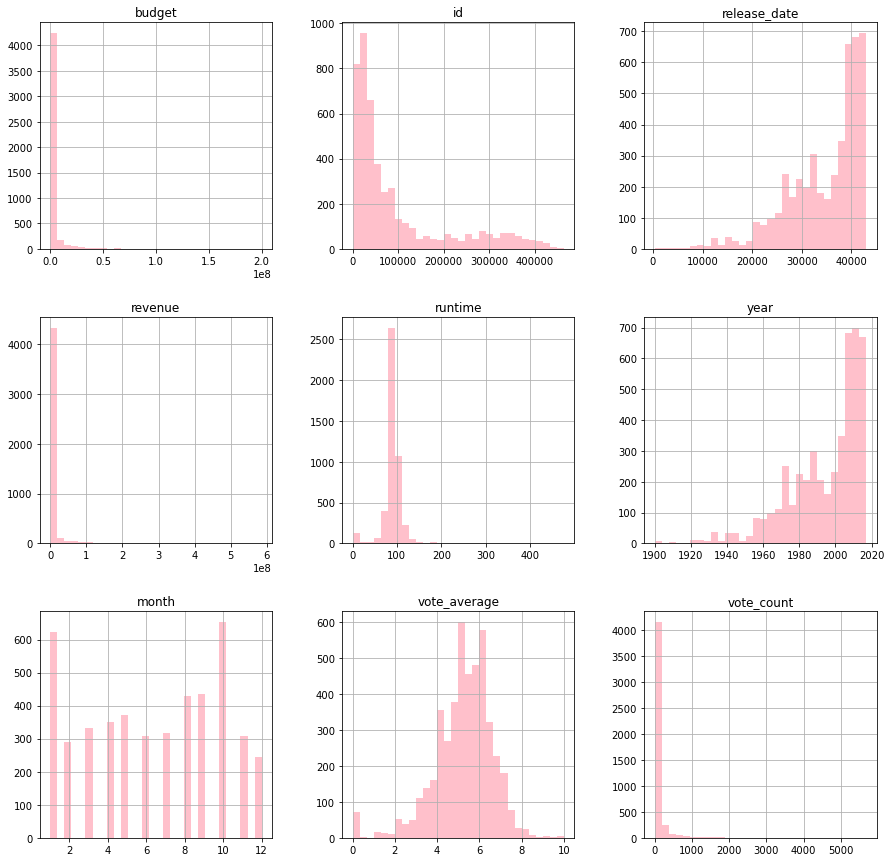

In [6]:
data_core.hist(bins=30,figsize=(15,15),color='pink')

Now we have all the columns we want, we are going to remove the rows which have a budget that is abnormally low and a vote_average that is abnormally low. These rows are mostly 0, as we can see from the histograms of the continuous features above. 

In [7]:
## filter out low budget, low revenue, low vote_count to clean data

#bad_rows = data_core[data_core['vote_average']<1].index
## THE FOLLOWING DOES NOT SEEM TO WORK
#bad_rows.append(data_core[data_core['budget']<10000].index)
#bad_rows.append(data_core[data_core['vote_count']<50].index)
##

data_filtered = data_core.copy()
data_filtered.drop(data_core[data_core['vote_average']<1].index, inplace=True)
data_filtered.drop(data_filtered[data_filtered['budget']<10000].index, inplace=True)

data_filtered.info()
data_filtered.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 4658
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                1218 non-null   int64  
 1   genres                1218 non-null   object 
 2   id                    1218 non-null   int64  
 3   original_language     1218 non-null   object 
 4   production_countries  1218 non-null   object 
 5   release_date          1218 non-null   float64
 6   revenue               1218 non-null   float64
 7   runtime               1218 non-null   float64
 8   title                 1218 non-null   object 
 9   year                  1218 non-null   int64  
 10  month                 1218 non-null   int64  
 11  cast                  1218 non-null   object 
 12  vote_average          1218 non-null   float64
 13  vote_count            1218 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 142.7+ KB


,budget,genres,id,original_language,production_countries,release_date,revenue,runtime,title,year,month,cast,vote_average,vote_count
1,19000000,"[Horror, Action, Thriller, Crime]",755,en,[United States of America],35083.0,25836616.0,108.0,From Dusk Till Dawn,1996,1,[George Clooney],6.9,1644.0
2,20000000,"[Horror, Science Fiction]",9102,en,"[Canada, Japan, United States of America]",34950.0,5781885.0,108.0,Screamers,1995,9,[Peter Weller],6.1,154.0
3,47000000,"[Drama, Horror, Thriller, Romance]",9095,en,[United States of America],35118.0,12379402.0,104.0,Mary Reilly,1996,2,[Julia Roberts],5.7,77.0
4,14000000,"[Comedy, Horror, Romance]",12158,en,[United States of America],34998.0,19800000.0,100.0,Vampire in Brooklyn,1995,10,[Eddie Murphy],4.5,113.0
9,35000000,"[Science Fiction, Horror, Action]",9348,en,[United States of America],34887.0,113374103.0,108.0,Species,1995,7,[Natasha Henstridge],5.5,457.0


We now have reduced our rows from 4667 to 1218 rows.

Here we have code to get the subset of the top movies, being movies that have a rating above 7.0
We will not be using this at the moment.

In [8]:
## Top Movies
bad_movies = data_filtered[data_filtered['vote_average']<7.0].index
top_movies = data_filtered.copy()
top_movies.drop(bad_movies, inplace=True)
top_movies.info()
top_movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 11 to 4448
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                90 non-null     int64  
 1   genres                90 non-null     object 
 2   id                    90 non-null     int64  
 3   original_language     90 non-null     object 
 4   production_countries  90 non-null     object 
 5   release_date          90 non-null     float64
 6   revenue               90 non-null     float64
 7   runtime               90 non-null     float64
 8   title                 90 non-null     object 
 9   year                  90 non-null     int64  
 10  month                 90 non-null     int64  
 11  cast                  90 non-null     object 
 12  vote_average          90 non-null     float64
 13  vote_count            90 non-null     float64
dtypes: float64(5), int64(4), object(5)
memory usage: 10.5+ KB


,budget,genres,id,original_language,production_countries,release_date,revenue,runtime,title,year,month,cast,vote_average,vote_count
11,60000000,"[Horror, Romance]",628,en,[United States of America],34649.0,223664608.0,123.0,Interview with the Vampire,1994,11,[Brad Pitt],7.2,1558.0
20,8000000,"[Horror, Mystery, Thriller]",2654,en,[United States of America],34680.0,8946600.0,95.0,In the Mouth of Madness,1994,12,[Sam Neill],7.1,307.0
32,4000000,"[Fantasy, Drama, Horror, Comedy]",21588,it,"[France, Germany, Italy]",34418.0,0.0,105.0,Cemetery Man,1994,3,[Rupert Everett],7.0,105.0
42,114000,[Horror],10331,en,[United States of America],25112.0,30000000.0,96.0,Night of the Living Dead,1968,10,[Duane Jones],7.5,591.0
50,18500000,"[Horror, Action, Thriller, Science Fiction]",679,en,"[United Kingdom, United States of America]",31611.0,183316455.0,137.0,Aliens,1986,7,[Sigourney Weaver],7.7,3282.0


## Data Exploration
In this section we will have some visualizations of the data we are working with. These will include histograms of the distributions of variables as well as plots of different variables against vote_average.

<AxesSubplot:>

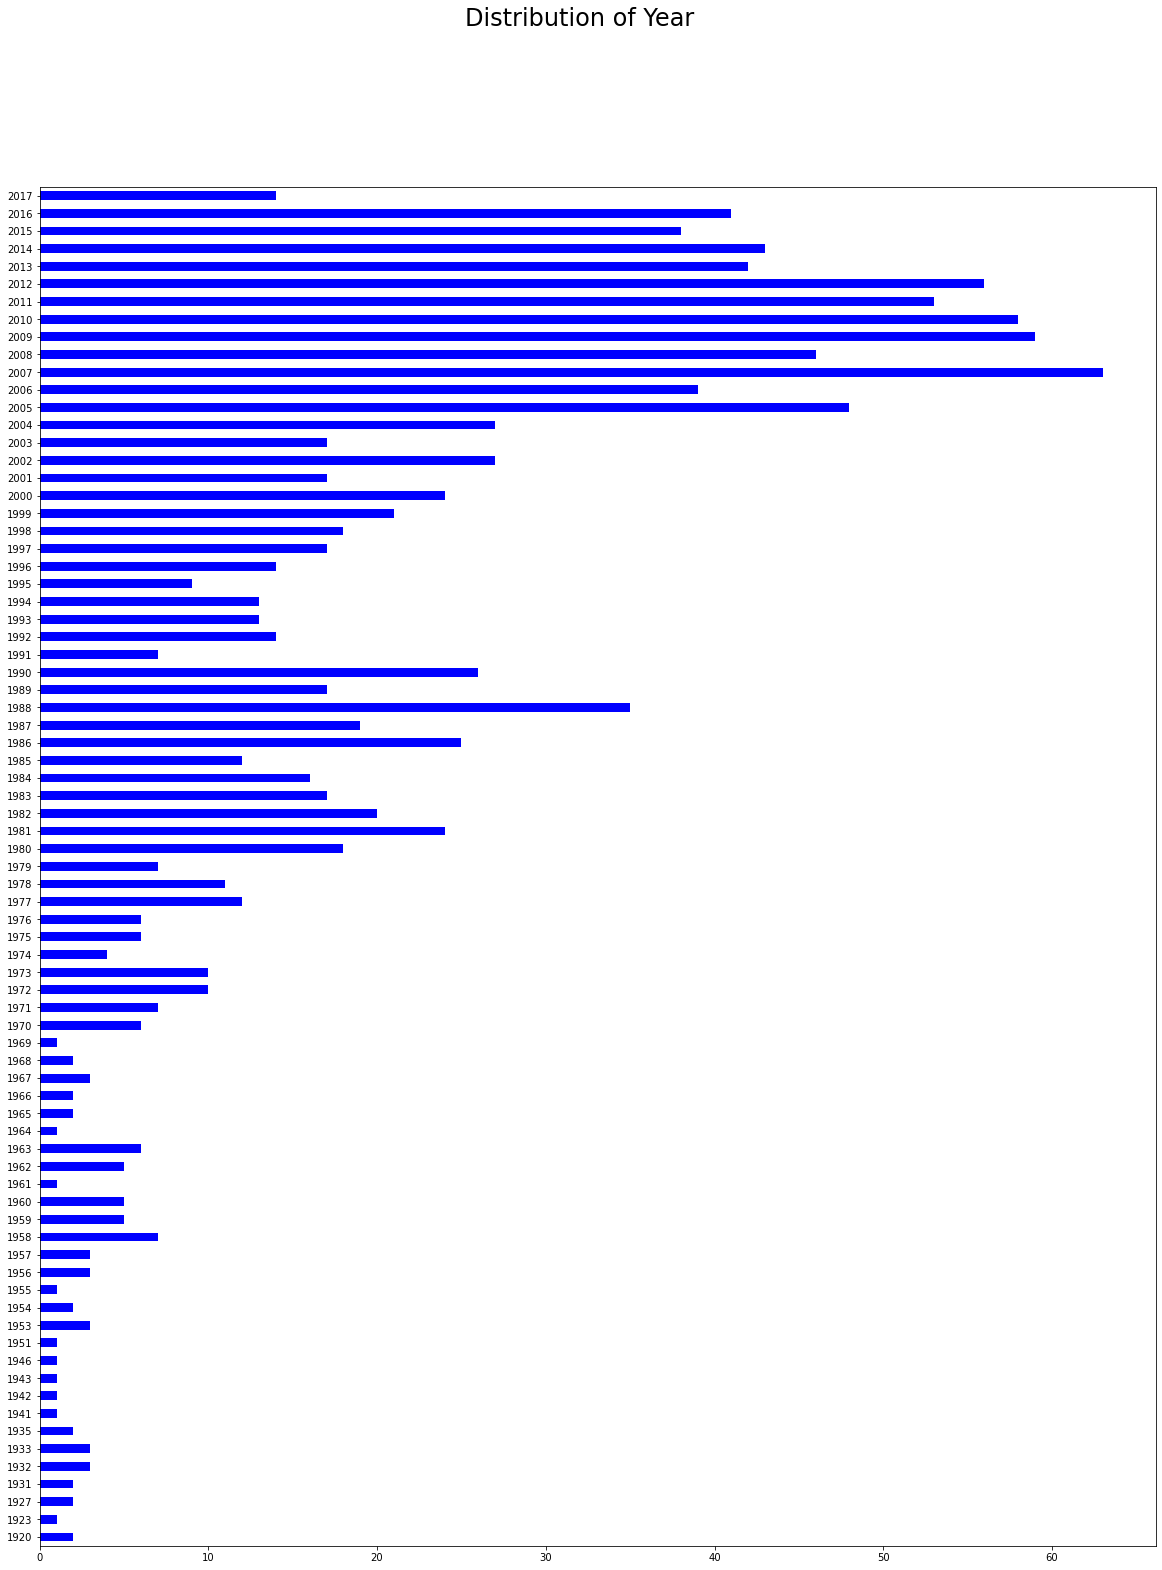

In [9]:
## Distribution of Year
plt.suptitle('Distribution of Year', size=24)
data_filtered['year'].value_counts(dropna=False).sort_index().plot(kind='barh',color='blue',figsize=(20,25))


<AxesSubplot:>

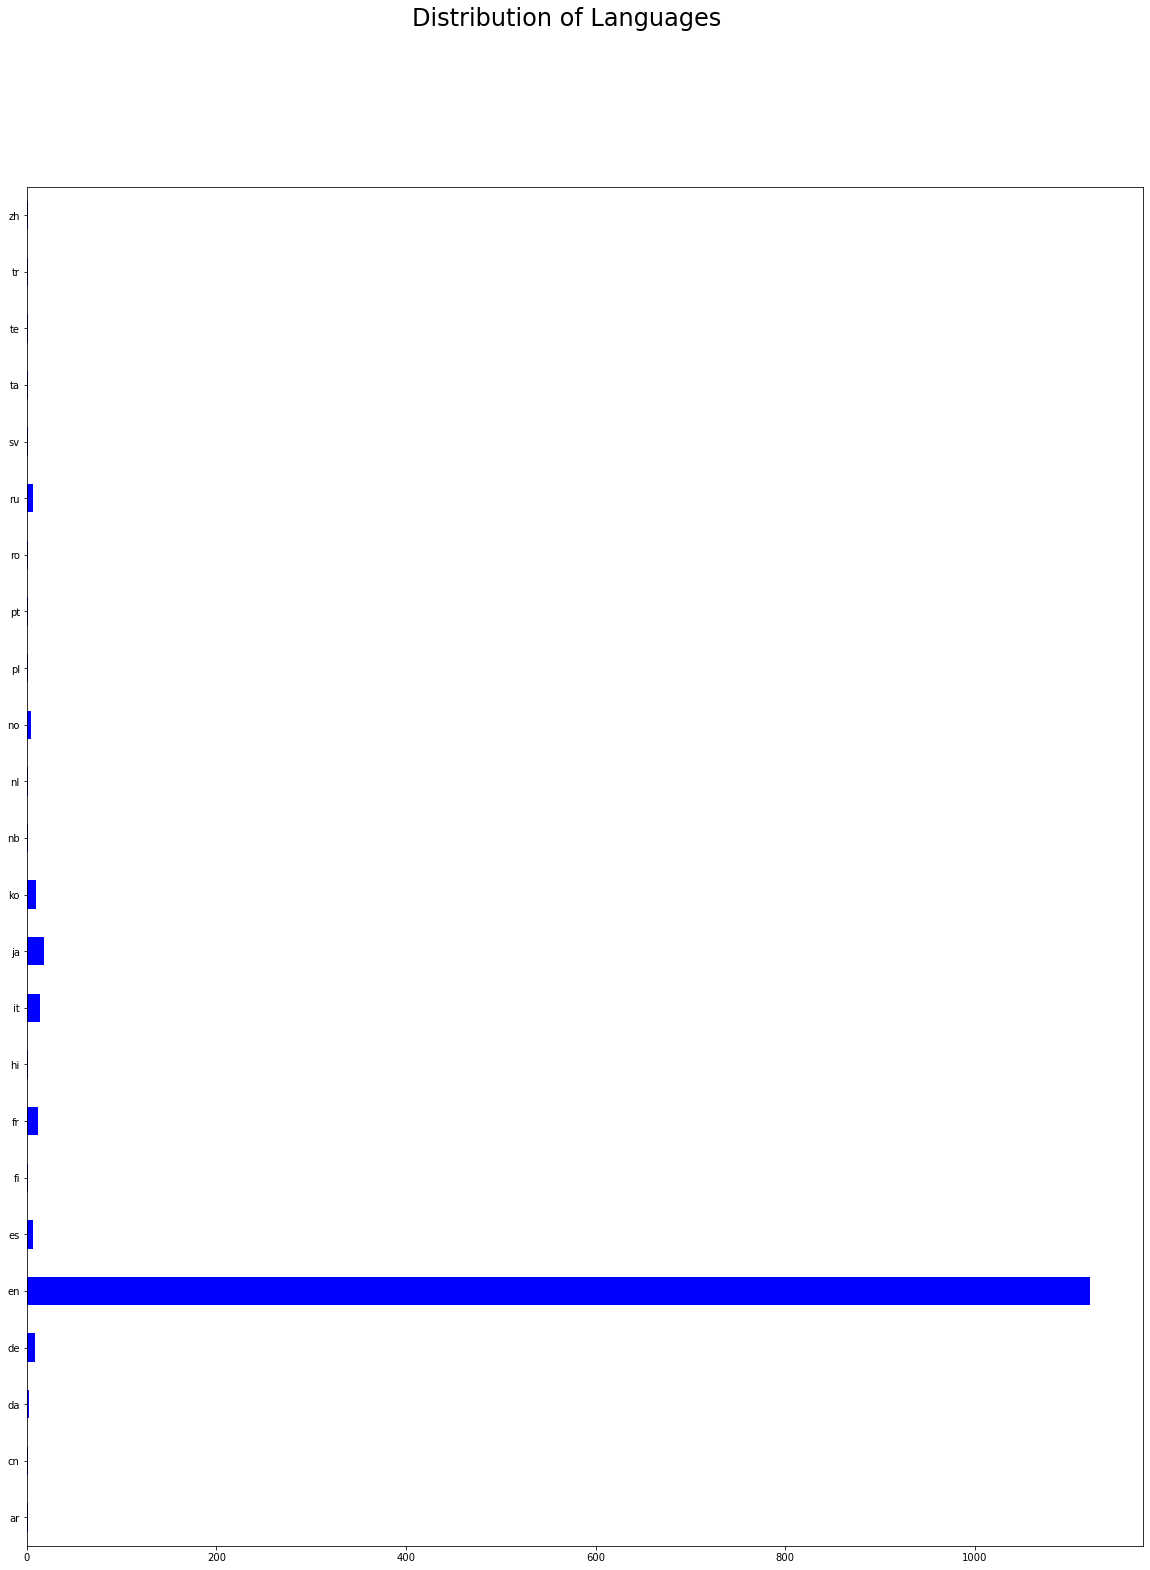

In [10]:
## Distribution of Languages
plt.suptitle('Distribution of Languages', size=24)
data_filtered['original_language'].value_counts(dropna=False).sort_index().plot(kind='barh',color='blue',figsize=(20,25))


<AxesSubplot:>

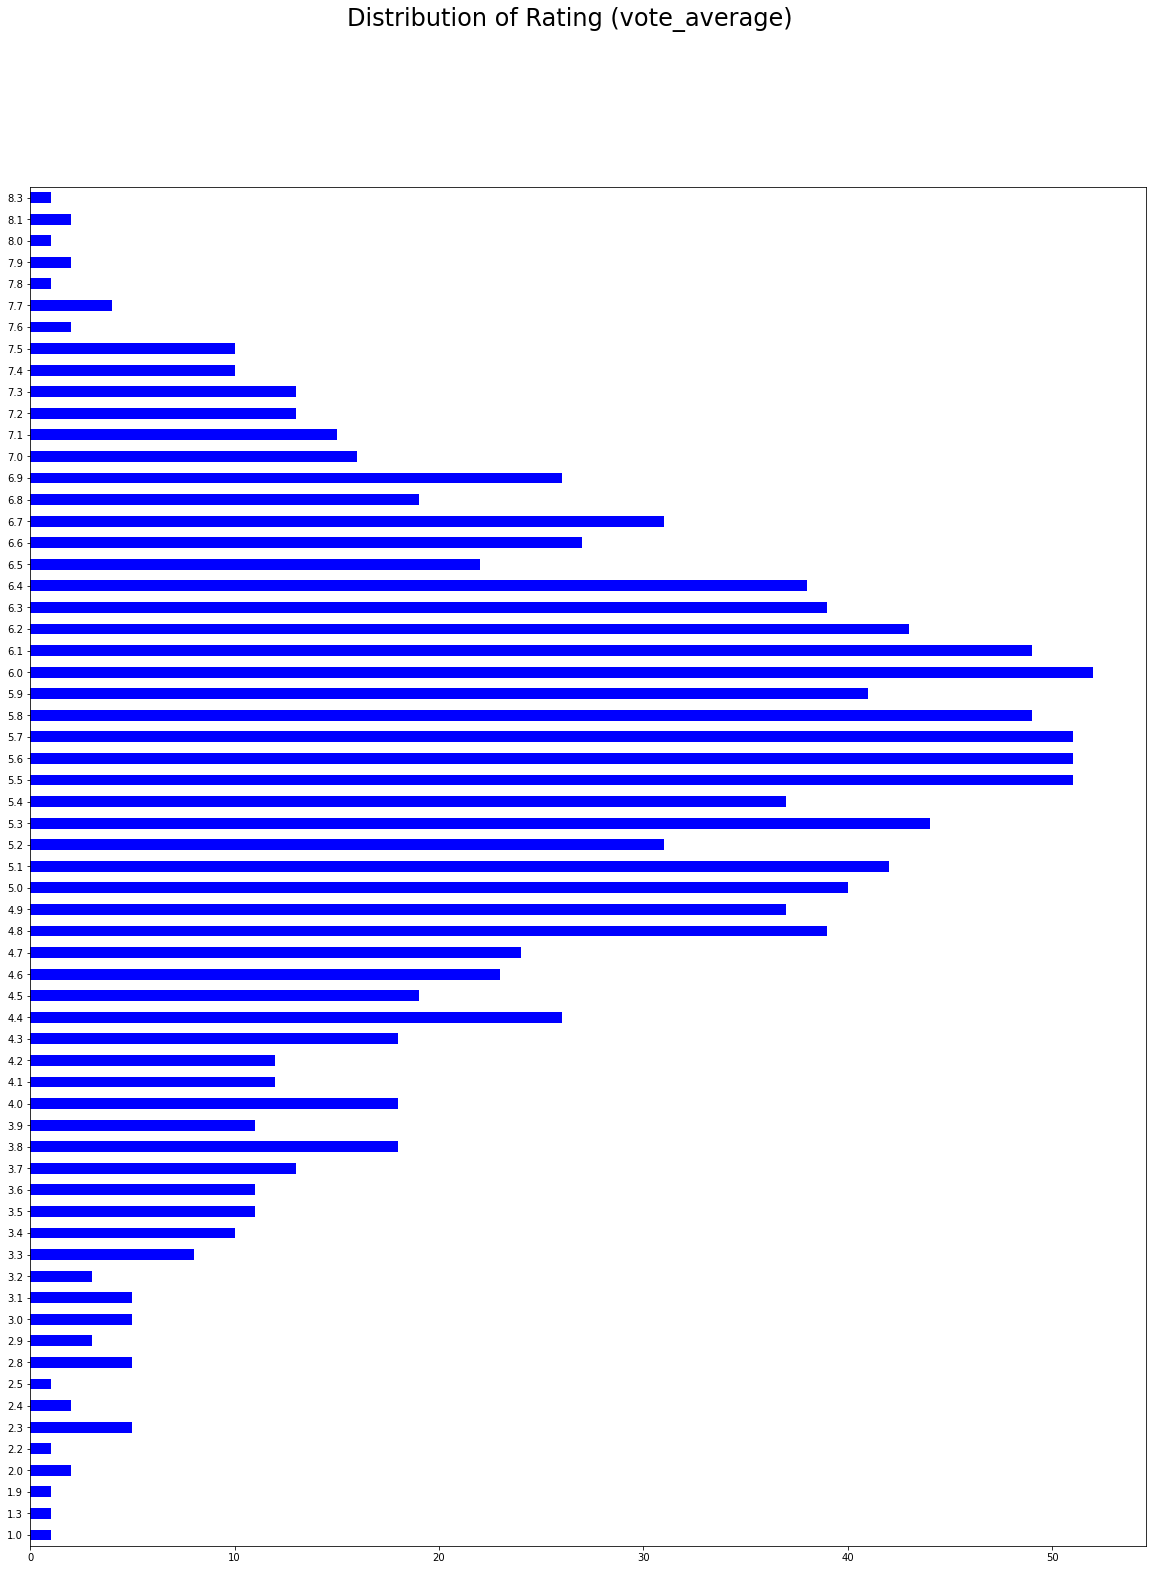

In [11]:
## Distribution of Rating
plt.suptitle('Distribution of Rating (vote_average)', size=24)
data_filtered['vote_average'].value_counts(dropna=False).sort_index().plot(kind='barh',color='blue',figsize=(20,25))


<AxesSubplot:>

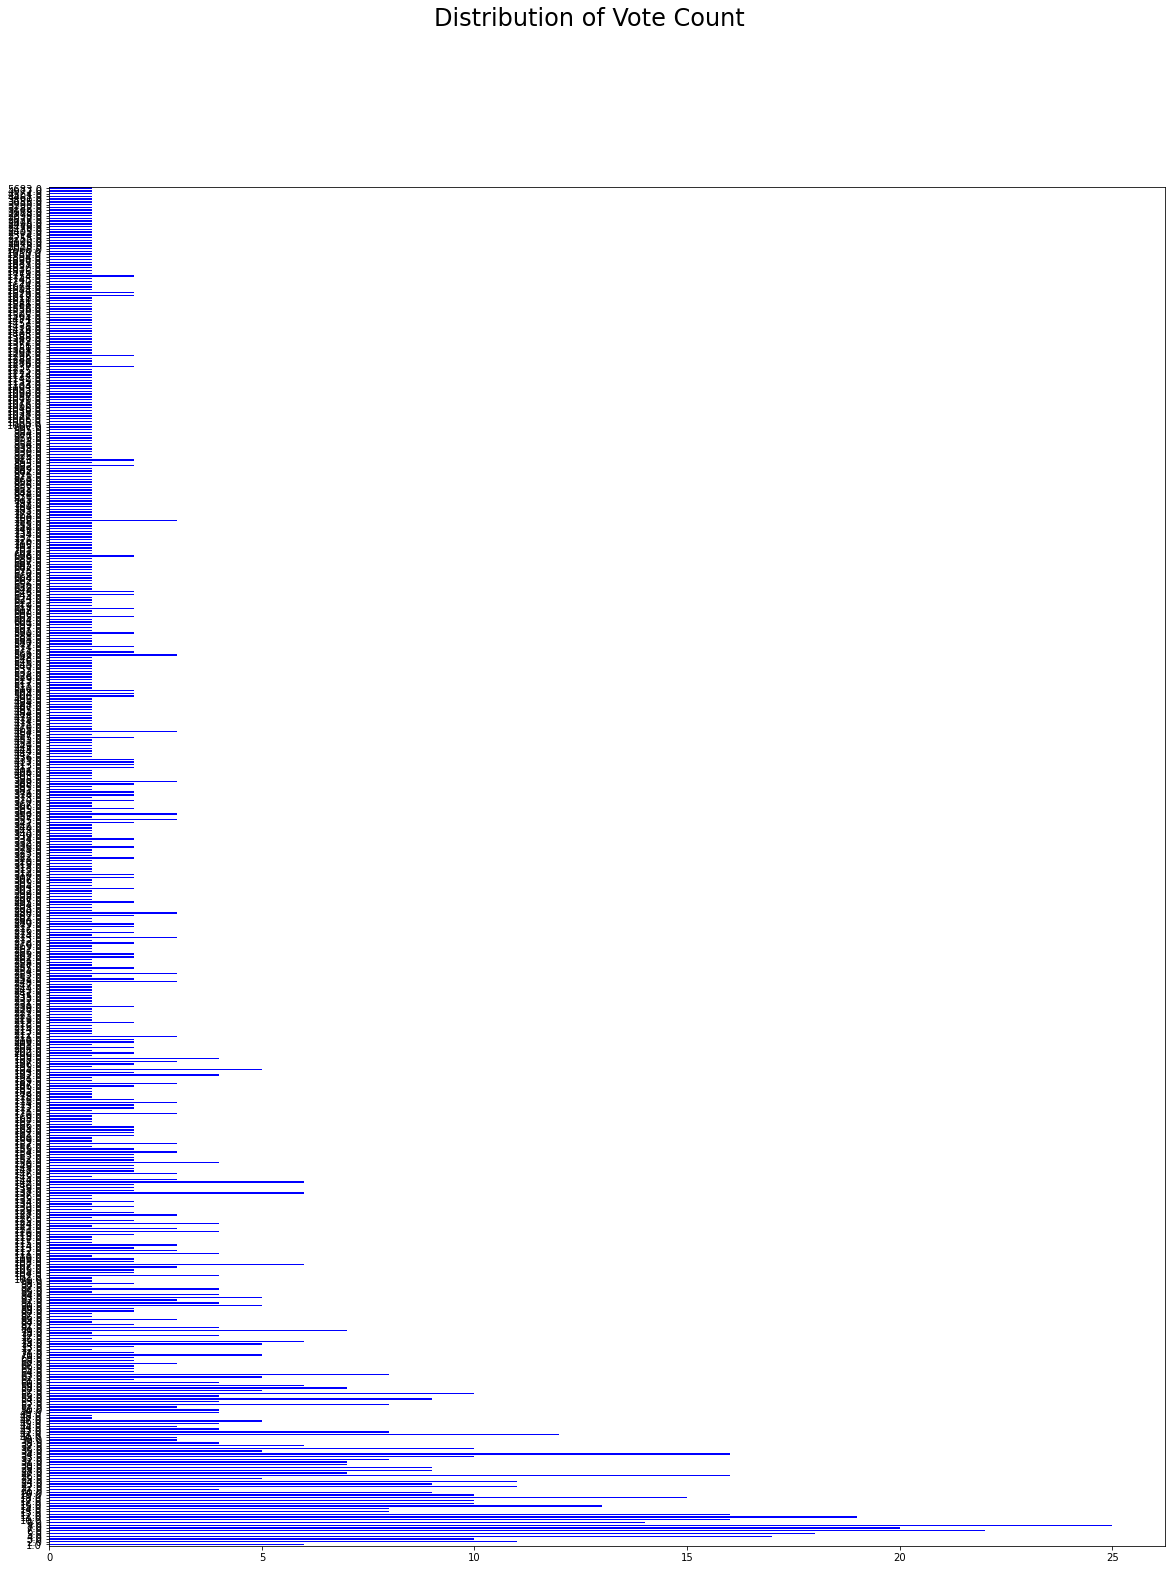

In [12]:
## Distribution of Vote Count
plt.suptitle('Distribution of Vote Count', size=24)
data_filtered['vote_count'].value_counts(dropna=False).sort_index().plot(kind='barh',color='blue',figsize=(20,25))


array([[<AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'release_date'}>],
       [<AxesSubplot:title={'center':'revenue'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'vote_average'}>,
        <AxesSubplot:title={'center':'vote_count'}>]], dtype=object)

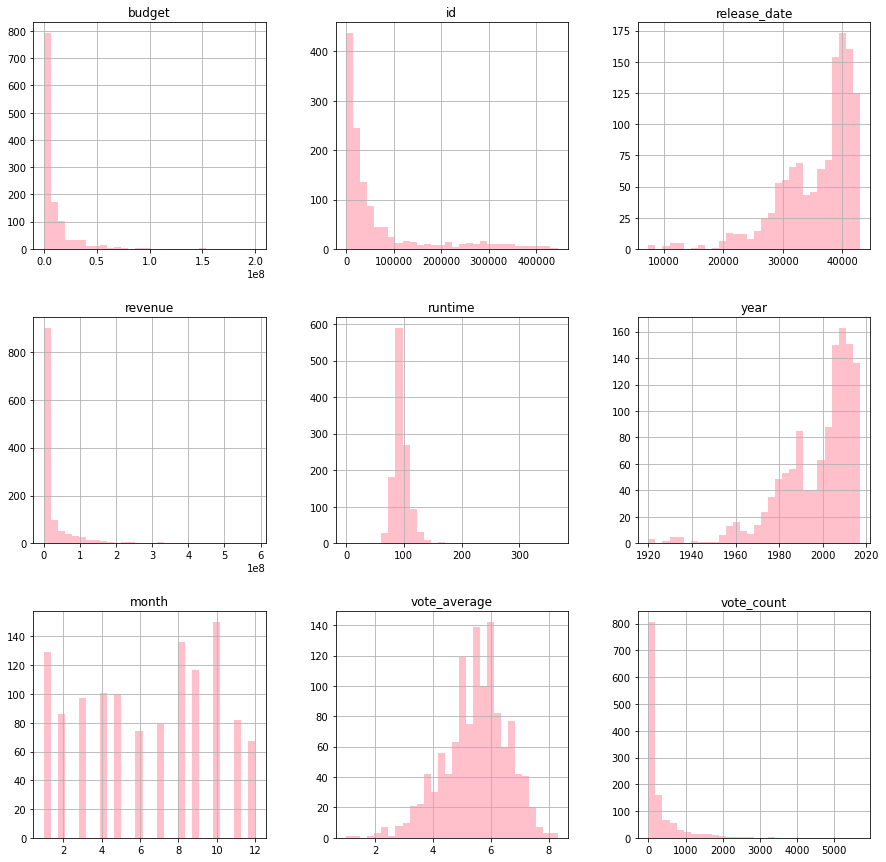

In [13]:
## Combined Distributions of continuous variables

data_filtered.hist(bins=30,figsize=(15,15),color='pink')

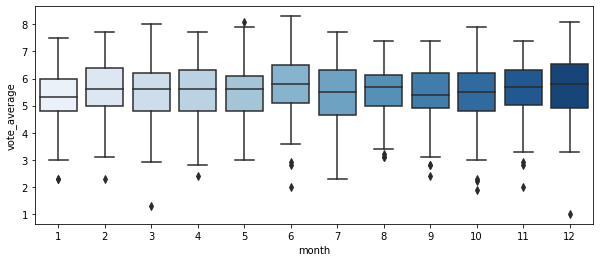

In [14]:
## Rating vs Month

fig, (ax) = plt.subplots(ncols=1, figsize=(10,4))
s = sns.boxplot(x='month', y="vote_average", data=data_filtered, palette="Blues",showfliers=True)
plt.show()



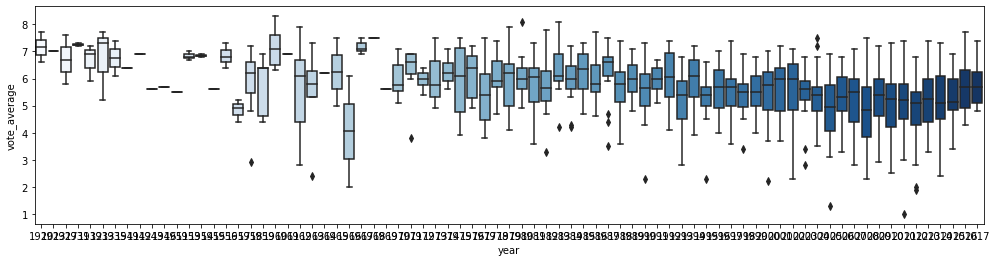

In [15]:
## Rating vs Year

fig, (ax) = plt.subplots(ncols=1, figsize=(17,4))
s = sns.boxplot(x='year', y="vote_average", data=data_filtered, palette="Blues",showfliers=True)
plt.show()


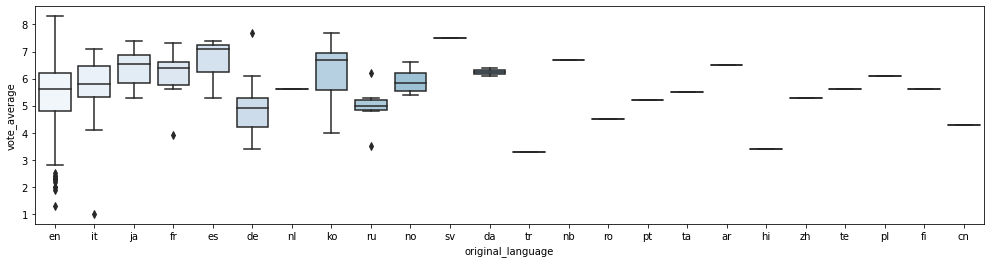

In [16]:
## Rating vs Language
fig, (ax) = plt.subplots(ncols=1, figsize=(17,4))
s = sns.boxplot(x='original_language', y="vote_average", data=data_filtered, palette="Blues",showfliers=True)
plt.show()


Here we get the set of data that only contains our continuous variables. We are also scaling it here, which is very important as the magnitudes of 'budget' are significantly higher than 'runtime', and not scaling will skew the data and how the model will interact with it.

In [17]:
## Set of Continuous data
data_continuous = data_filtered[['budget','revenue','runtime','vote_count']].copy()
data_continuous = data_continuous.astype('float32')

## This is the Y portion of the data which we will be using later
data_y = data_filtered['vote_average'].copy()

## Scaling the data
scaler = MinMaxScaler()
data_continuous[data_continuous.columns] = scaler.fit_transform(data_continuous[data_continuous.columns]) 

data_continuous.head(10)

,budget,revenue,runtime,vote_count
1,0.094955,0.044139,0.295082,0.289159
2,0.099955,0.009878,0.295082,0.026927
3,0.234962,0.021149,0.284153,0.013376
4,0.069954,0.033826,0.273224,0.019711
9,0.174959,0.193686,0.295082,0.080253
11,0.299965,0.382105,0.336066,0.274023
12,0.224961,0.191350,0.336066,0.047694
13,0.023951,0.000000,0.243169,0.000528
16,0.029951,0.020501,0.267760,0.005632
18,0.069954,0.030905,0.306011,0.052094


Here is a visualization of the correlation between the continuous variables and each other:

<AxesSubplot:>

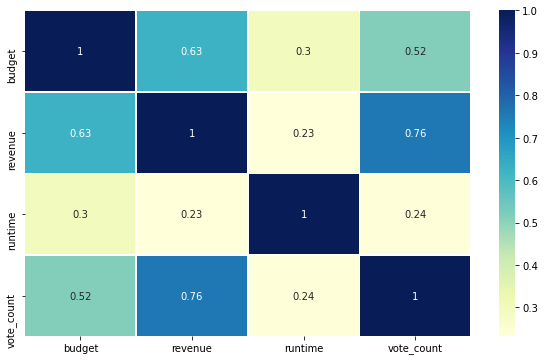

In [18]:
## Visualizing correlations between continuous data
correlations = data_continuous.corr()
f,ax = plt.subplots(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", linewidths=.5)

We will notice a notable correlation between vote_count and revenue. This makes sense as movies with higher revenue mean that they generated a lot of views, thus the count of the votes would be higher as the movies garnered a larger population of viewers, which means more people that will vote on the movie.

We can also see a correlation, though weaker, between budget and revenue. This also makes sense as typically movies with a higher budget pull in more revenue. High budget movies also need more revenue by necessity in order to break even and be a profitable venture.

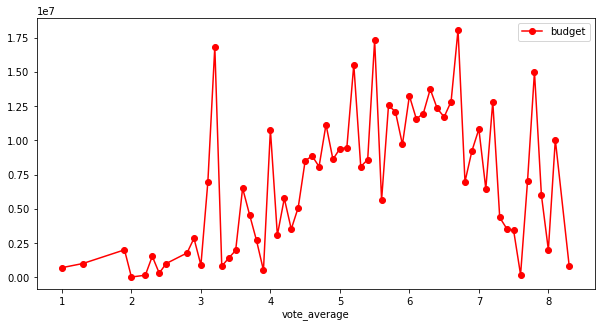

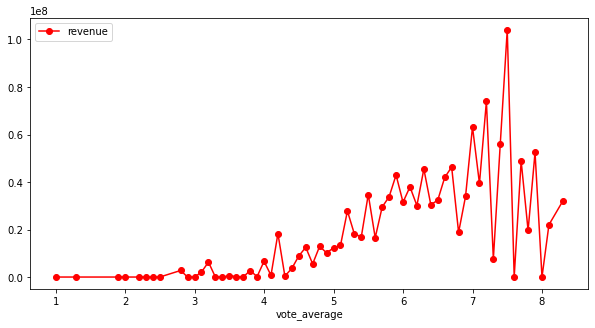

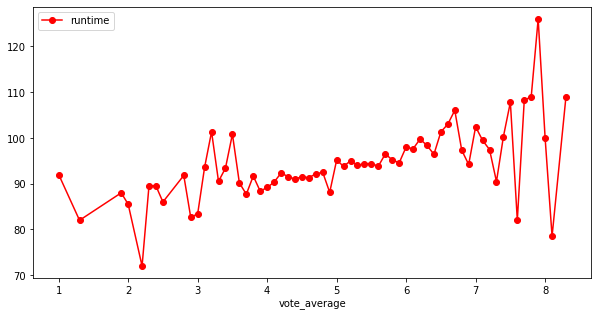

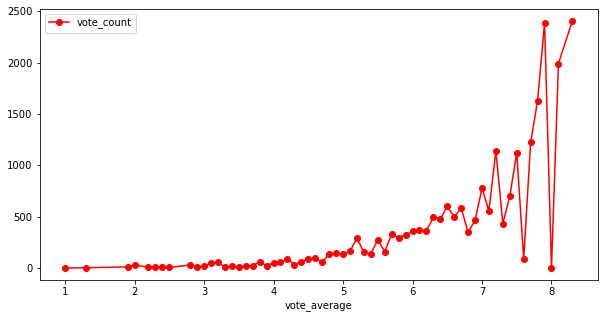

In [19]:
## Relations between continuous variables and Rating

for i in data_continuous.columns:
    axis = data_filtered.groupby('vote_average')[[i]].mean().plot(figsize=(10,5),marker='o',color='r')

Above are some more relations of the continuous data features against vote_average.

We will notice that **budget** seems to be more evenly distributed, which is a little surprising. One might think that a higher budget will lead to a better vote_average, as we initially thought.
We can see however that **revenue** seems to be displaying this relation. This in fact makes sense, similar to what we discussed previously with revenue and vote_count. Higher revenue means the movie was seen by more people, thus it will have more votes, and a higher revenue movie means that typically it was "popular" in some sense, thus having a generally higher vote_average.

We can see the connection between **vote_count** and **vote_average** here as well.

**Runtime** did not seem to have much of a connection.

## Data Transformation - Encoding
In this section we will go through our categorical features and encode them such that they can be used further in analysis.

Note that we are treating year and month as categories. Though these are numbers and could be treated as continuous, this would not make sense as it would be putting a value associated with the month (or year). In reality, we know that Decemeber is not "more" than May, hence why we treat them as categories.

In [20]:
## Binarizing genres
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(data_filtered['genres']),
                   columns=mlb.classes_,
                   index=data_filtered['genres'].index)
#remove horror as a genre as we are already looking only at horror movies
del genres_encoded['Horror']
genres_encoded.head()

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Foreign,History,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [21]:
## Binarizing production_countries
mlb = MultiLabelBinarizer()
countries_encoded = pd.DataFrame(mlb.fit_transform(data_filtered['production_countries']),
                   columns=mlb.classes_,
                   index=data_filtered['production_countries'].index)

countries_encoded.head()

,Angola,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Czech Republic,Denmark,Egypt,Estonia,Finland,France,Georgia,Germany,Hong Kong,Hungary,Iceland,India,Indonesia,Ireland,Israel,Italy,Japan,Luxembourg,Malta,Mexico,Namibia,Netherlands,New Zealand,Norway,Peru,Philippines,Poland,Portugal,Romania,Russia,Serbia,Singapore,South Africa,South Korea,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States of America
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


NOTE THAT WE ARE NOT USING CAST due to the overwhelming variance in actors.

In [22]:
## Binarizing cast
mlb = MultiLabelBinarizer()
cast_encoded = pd.DataFrame(mlb.fit_transform(data_filtered['cast']),
                   columns=mlb.classes_,
                   index=data_filtered['cast'].index)

cast_encoded.info()
cast_encoded.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 4658
Columns: 1009 entries, A. Michael Baldwin to 杰森·莫玛
dtypes: int32(1009)
memory usage: 4.7 MB


,A. Michael Baldwin,Aaron Eckhart,Aaron Stanford,Adam Kaufman,Adam Scott,Adelaide Clemens,Adrian Pasdar,Adrian Țofei,Adrien Brody,Adrienne Barbeau,Akira Takarada,Akira Yamauchi,Akçay Karaazmak,Al Santos,Alan Cumming,Alan Ormsby,Alan Tudyk,Alan van Sprang,Albert Brooks,Albert Finney,Alberto Amarilla,Alex Barnett,Alex Rebar,Alex Vincent,Alexandra Daddario,Alexandra Wescourt,Ali Cobrin,Ali Larter,Alice Eve,Alicia Silverstone,Alicia Witt,Alina Babak,Alison Lohman,Alla Nazimova,Allison Hayes,Allison Miller,Ally Sheedy,Alycia Debnam-Carey,Alyssa Milano,Amanda Donohoe,Amanda Seyfried,Amber Heard,Amy Steel,Andre Gower,Andrew Divoff,Andrew Jacobs,Andrew Robinson,Aneliese Roettger,Anessa Ramsey,Angela Bettis,Angus Scrimm,Anita Skinner,Anna Gunndís Guðmundsdóttir,Anna Paquin,Annabelle Wallis,Anthony Alviano,Anthony Hopkins,Anthony Perkins,Anton Yelchin,Antonio Banderas,Anya Taylor-Joy,April Monique Burril,Arch Hall Jr.,Ariauna Albright,Arkadiusz Jakubik,Arnold Schwarzenegger,Arron Kinser,Arthur Berning,Ashley Bell,Ashley Benson,Ashley Gallo,Ashley Grace,Ashley Greene,Ashley Judd,Asia Argento,Aubrey Plaza,Audrey Hepburn,Austin Nichols,Axel Jodorowsky,Barbara Bach,Barbara Cupisti,Barbie Hsu,Basil Rathbone,Baya Rehaz,Bel Deliá,Bela Lugosi,Bella Heathcote,Ben Foster,Ben Murphy,Ben Syder,Benicio del Toro,Benjamin Walker,Betsy Palmer,Bette Davis,Bijou Phillips,Bill Oberst Jr.,Bill Paxton,Bill Pullman,Billie Piper,Billy Brown,Billy Connolly,Billy Zane,Blake Lively,Blake Woodruff,Bo Linton,Bobbie Phillips,Bobby Campo,Boris Karloff,Brad Dourif,Brad Pitt,Bradley Cooper,Brandon Maggart,Brandon Quintin Adams,Brandon Routh,Brenda Siemer Scheider,Brenda Vaccaro,Brian Cox,Brian Daniel Heffron,Brian Klugman,Brian Krause,Brian Matthews,Brian O'Halloran,Brian Salzberg,Brianna Brown,Brigid Brannagh,Brittany Curran,Bruce Campbell,Bruce Dern,Bruce Payne,Bruce Ramsay,Bruno Campos,Bruno Espejo,Burt Lancaster,Béatrice Dalle,Bérénice Bejo,C. Thomas Howell,Caitlyn Folley,Caleb Landry Jones,Cameron Mitchell,Camilla Belle,Camille Keaton,Candace Hilligoss,Carice van Houten,Carrie Gemmell,Cary Elwes,Cassidy Gifford,Cate Blanchett,Catherine Deneuve,Catherine Hicks,Catherine Mary Stewart,Catherine Steadman,Cathy Podewell,Charisma Carpenter,Charles Bronson,Charles Clary,Charles Napier,Charlie Cox,Charlie Sheen,Charlotte Frogner,Chelsey Crisp,Chloé Coulloud,Chloë Grace Moretz,Chloë Sevigny,Chris Diamantopoulos,Chris J. Murray,Chris Jarvis,Chris Johnson,Chris Makepeace,Chris Messina,Chris Riggi,Chris Sarandon,Christian Slater,Christine Lakin,Christopher Connelly,Christopher George,Christopher Judge,Christopher Kriesa,Christopher Lambert,Christopher Lee,Christopher Stacey,Christopher Walken,Chuck Norris,Cillian Murphy,Claire Holt,Clancy Brown,Clare Higgins,Clarence Williams III,Claude Rains,Claudette Mink,Clay Rogers,Cliff DeYoung,Clint Howard,Clive Owen,Clu Gulager,Clyde Hayes,Cole Hauser,Colin Clive,Connie Mason,Corbin Bernsen,Corin Nemec,Cortney Palm,Cotter Smith,Craig Sheffer,Craig T. Nelson,Craig Wasson,Crispin Glover,Cristi Harris,Cristina Marsillach,Cuba Gooding Jr.,D. B. Sweeney,Daisy Keeping,Dale Midkiff,Daliah Lavi,Dan Grimaldi,Dana Kimmell,Dane DeHaan,Daniel Kaluuya,Daniel Radcliffe,Daniel Usaj,Danielle Dallacco,Danielle Harris,Danielle Panabaker,Danny Trejo,Daryl Hannah,David A. Lockhart,David Anders,David Andrews,David Arquette,David Carradine,David Edwin Knight,David Emge,David Hedison,David Huffman,David Keith,David Kross,David Mattey,David Miller,David Naughton,David Schofield,David Selby,David Soul,Dean Winters,Deborah Foreman,Deborah Harry,Dee Wallace,Delia Sheppard,Dennis Hopper,Dennis Miller,Dennis Quaid,Derek Mears,Dermot Mulroney,Desiree Hall,Desmond Harrington,Devon Sawa,Devon Werkheiser,Diane Ladd,Dick Miller,Dieter Laser,Divine,Dolph Lundgren,Dominique Swain,Donald Pleasence,Donald Sutherland,Doug Hutchison,Douglas Smith,Dougray Scott,Duane Jones,Dwayne Johnson,Dyanne Thorne,Dylan McDermott,Ed Gale,Eddie Murphy,Edith Meeks,Eduardo Noriega,Edward Al

In [23]:
## Encoding language
languages_encoded = pd.get_dummies(data_filtered['original_language'])

languages_encoded.head()

,ar,cn,da,de,en,es,fi,fr,hi,it,ja,ko,nb,nl,no,pl,pt,ro,ru,sv,ta,te,tr,zh
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
## Encoding year
year_encoded = pd.get_dummies(data_filtered['year'])

year_encoded.head()

,1920,1923,1927,1931,1932,1933,1935,1941,1942,1943,1946,1951,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
## Encoding month
month_encoded = pd.get_dummies(data_filtered['month'])

month_encoded.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0


## Final Data
Here we have the final form of the data we will be using for analysis

In [26]:
## ALL DATA
data_finalx=data_continuous.join(languages_encoded).join(year_encoded).join(month_encoded).join(genres_encoded).join(countries_encoded)
data_finalx.info()
data_finalx.head(20)
#print(data_finalx)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 4658
Columns: 186 entries, budget to United States of America
dtypes: float32(4), int32(69), uint8(113)
memory usage: 531.2 KB


,budget,revenue,runtime,vote_count,ar,cn,da,de,en,es,fi,fr,hi,it,ja,ko,nb,nl,no,pl,pt,ro,ru,sv,ta,te,tr,zh,1920,1923,1927,1931,1932,1933,1935,1941,1942,1943,1946,1951,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,1,2,3,4,5,6,7,8,9,10,11,12,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Foreign,History,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,Angola,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Czech Republic,Denmark,Egypt,Estonia,Finland,France,Georgia,Germany,Hong Kong,Hungary,Iceland,India,Indonesia,Ireland,Israel,Italy,Japan,Luxembourg,Malta,Mexico,Namibia,Netherlands,New Zealand,Norway,Peru,Philippines,Poland,Portugal,Romania,Russia,Serbia,Singapore,South Africa,South Korea,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States of America
1,0.094955,0.044139,0.295082,0.289159,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.099955,0.009878,0.295082,0.026927,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.234962,0.021149,0.284153,0.013376,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.069954,0.033826,0.273224,0.019711,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0.174959,0.193686,0.295082,0.080253,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11,0.299965,0.382105,0.336066,0.274023,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12,0.224961,0.191350,0.336066,0.047694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
13,0.023951,0.000000,0.243169,0.000528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

Next we need to get the X and Y for our model.

In [27]:
## Get X and Y for model
data_x = data_finalx.copy()

data_x.head()

## Note that we have already gotten data_y from before, code as follows
#data_y = data_continuous['vote_average'].copy()

data_y.head(20)

1     6.9
2     6.1
3     5.7
4     4.5
9     5.5
11    7.2
12    6.1
13    4.0
16    5.4
18    6.4
20    7.1
21    5.8
23    6.4
26    4.9
31    6.3
32    7.0
36    6.7
38    5.0
39    5.8
40    4.6
Name: vote_average, dtype: float64

In [28]:
data_x.head(20)

,budget,revenue,runtime,vote_count,ar,cn,da,de,en,es,fi,fr,hi,it,ja,ko,nb,nl,no,pl,pt,ro,ru,sv,ta,te,tr,zh,1920,1923,1927,1931,1932,1933,1935,1941,1942,1943,1946,1951,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,1,2,3,4,5,6,7,8,9,10,11,12,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Foreign,History,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,Angola,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Czech Republic,Denmark,Egypt,Estonia,Finland,France,Georgia,Germany,Hong Kong,Hungary,Iceland,India,Indonesia,Ireland,Israel,Italy,Japan,Luxembourg,Malta,Mexico,Namibia,Netherlands,New Zealand,Norway,Peru,Philippines,Poland,Portugal,Romania,Russia,Serbia,Singapore,South Africa,South Korea,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States of America
1,0.094955,0.044139,0.295082,0.289159,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.099955,0.009878,0.295082,0.026927,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.234962,0.021149,0.284153,0.013376,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.069954,0.033826,0.273224,0.019711,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0.174959,0.193686,0.295082,0.080253,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11,0.299965,0.382105,0.336066,0.274023,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12,0.224961,0.191350,0.336066,0.047694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
13,0.023951,0.000000,0.243169,0.000528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

We will be using sklearn's train_test_split method to split our dataset 80% Train 20% Test for use with our models.

In [29]:
## Get TRAIN and TEST partitions
#using sklearn train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.20)

#convert to dataframe, otherwise they are series and seem to cause issues later
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

#Y_train.info()


(974, 186) (244, 186) (974, 1) (244, 1)


## Supervised Learning Models
In this section we will be creating and evaluating 4 supervised Keras models. Using Deep Neural Networks and varying the parameters and shape of the network, we will see how they perform.

As we are doing linear regression because we are predicting the continuous class variable **vote_average**, we will be testing the performance of the model by measuring our loss with **mean squared error**.
We will then take a look at the predicted values of the train set against the actual vote_average values of the train set. We will also visualize this using a histogram distribution of the error.

In [30]:
n_features = X_train.shape[1]
print(n_features)

186


### MODEL 1
Our first supervised learning module uses a simple neural net containing one layer and a smaller number of nodes. It is our hypothesis this will be the least accurate classifier of our supervised learning algorithms. We are only using one hidden layer, and a small amount of nodes. This is not a very complex network, but it should still be able to make predictions with decent accuracy. We can see how it performed on the training set below.

In [31]:
## KERAS MODEL 1
# Our first will be a simple neural network with one hidden layer and a small number of nodes

##Defining the model
model_1 = Sequential()
model_1.add(Dense(4, activation='relu', input_shape=(n_features,)))
#hidden layer
model_1.add(Dense(2, kernel_initializer='he_normal'))
#output node
model_1.add(Dense(1))

# compiling the model
model_1.compile(optimizer='adam', loss='mse')

# fitting the model to the training data
model_1.fit(X_train, Y_train, epochs=50, verbose=1)

# save model
#model_1.save()

Train on 974 samples
Epoch 1/50
974/974 [==============================] - 0s 260us/sample - loss: 28.1206
Epoch 2/50
974/974 [==============================] - 0s 22us/sample - loss: 23.1490
Epoch 3/50
974/974 [==============================] - 0s 21us/sample - loss: 15.4361
Epoch 4/50
974/974 [==============================] - 0s 22us/sample - loss: 7.9565
Epoch 5/50
974/974 [==============================] - 0s 22us/sample - loss: 3.6575
Epoch 6/50
974/974 [==============================] - 0s 20us/sample - loss: 2.2112
Epoch 7/50
974/974 [==============================] - 0s 22us/sample - loss: 1.8923
Epoch 8/50
974/974 [==============================] - 0s 22us/sample - loss: 1.7526
Epoch 9/50
974/974 [==============================] - 0s 21us/sample - loss: 1.6361
Epoch 10/50
974/974 [==============================] - 0s 22us/sample - loss: 1.5312
Epoch 11/50
974/974 [==============================] - 0s 22us/sample - loss: 1.4426
Epoch 12/50
974/974 [============================

### Model 1 Performance

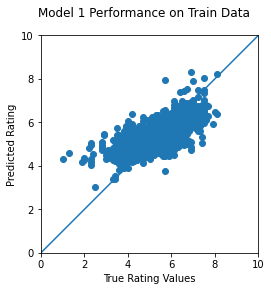

In [32]:
## MODEL 1 PERFORMANCE
#graphing the model predictions vs actuals of training set

train_predictions_1 = model_1.predict(X_train).flatten()

a = plt.axes(aspect='equal')
plt.scatter(Y_train, train_predictions_1)
plt.suptitle('Model 1 Performance on Train Data')
plt.xlabel('True Rating Values')
plt.ylabel('Predicted Rating')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ =plt.plot(lims, lims)

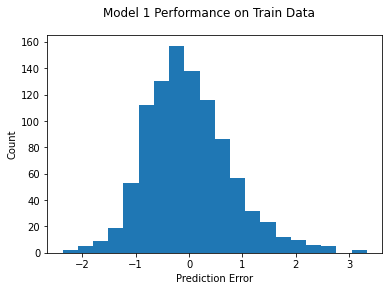

In [33]:
## MODEL 1 PERFORMANCE
#graphing distribution of model error (prediction vs actual) of training set

#ytrain_1= Y_train['vote_average']

error_1 = train_predictions_1 - Y_train['vote_average']
plt.hist(error_1, bins=20)
plt.suptitle('Model 1 Performance on Train Data')
plt.xlabel('Prediction Error')
_=plt.ylabel('Count')


### Analysis
This is a simple model and is not the most accurate with its predictions. That being said, we need to be careful to avoid overfitting on the training set, which will make the model perform poorly on unseen data. Examining the graph our model worked relatively well closely bunching to the true vs predicted slope. It did however, have a tendency to greatly over predict  very low rated movies. The model actually never appears to predict a rating lower than 3. Model 1 also tends when predicting a movie either slightly under predict the rating while more greatly over predicting the ratings. This can be seen by the longer tail on the distribution curve in the figure above.

### MODEL 2
It is our hypothesis that as we add hidden layers and nodes to the neural network that the ‘accuracy’ will increase and that the loss will decrease. We have added another hidden layer to this model and have increased the number of nodes through the layers.

In [34]:
## KERAS MODEL 2
# Our second model will be a neural network with two hidden layer and more nodes

##Defining the model
model_2 = Sequential()
model_2.add(Dense(8, activation='relu', input_shape=(n_features,)))
#hidden layer
model_2.add(Dense(4, kernel_initializer='he_normal'))
model_2.add(Dense(2, kernel_initializer='he_normal'))
#output node
model_2.add(Dense(1))

# compiling the model
model_2.compile(optimizer='adam', loss='mse')

# fitting the model to the training data
model_2.fit(X_train, Y_train, epochs=50, verbose=1)


Train on 974 samples
Epoch 1/50
974/974 [==============================] - 0s 260us/sample - loss: 26.6798
Epoch 2/50
974/974 [==============================] - 0s 25us/sample - loss: 18.3117
Epoch 3/50
974/974 [==============================] - 0s 25us/sample - loss: 8.9921
Epoch 4/50
974/974 [==============================] - 0s 24us/sample - loss: 3.1175
Epoch 5/50
974/974 [==============================] - 0s 25us/sample - loss: 1.9567
Epoch 6/50
974/974 [==============================] - 0s 24us/sample - loss: 1.7643
Epoch 7/50
974/974 [==============================] - 0s 23us/sample - loss: 1.6118
Epoch 8/50
974/974 [==============================] - 0s 22us/sample - loss: 1.4805
Epoch 9/50
974/974 [==============================] - 0s 23us/sample - loss: 1.3729
Epoch 10/50
974/974 [==============================] - 0s 23us/sample - loss: 1.2755
Epoch 11/50
974/974 [==============================] - 0s 24us/sample - loss: 1.1962
Epoch 12/50
974/974 [=============================

### Model 2 Performance

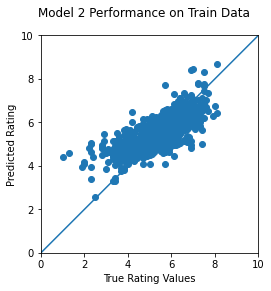

In [35]:
## MODEL 2 PERFORMANCE
#graphing the model predictions vs actuals of training set

train_predictions_2 = model_2.predict(X_train).flatten()

a = plt.axes(aspect='equal')
plt.scatter(Y_train, train_predictions_2)
plt.suptitle('Model 2 Performance on Train Data')
plt.xlabel('True Rating Values')
plt.ylabel('Predicted Rating')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ =plt.plot(lims, lims)

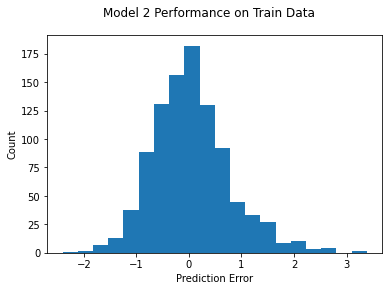

In [36]:
## MODEL 2 PERFORMANCE
#graphing distribution of model error (prediction vs actual) of training set

error_2 = train_predictions_2 - Y_train['vote_average']
plt.hist(error_2, bins=20)
plt.suptitle('Model 2 Performance on Train Data')
plt.xlabel('Prediction Error')
_=plt.ylabel('Count')

### Analysis
Through analyzing the figures  Model 2’s plot appears to pack tighter towards the perfect prediction slope on the training data. This shows that the accuracy is increasing on the training data. However,  the model continues to over-predict movies with very low ratings. The graph of prediction error also appears to be slightly more centered around 0. However, as layers  and nodes continue to be increased the probability of overfitting the data also increases, which could make it less accurate on testing data. We will explore this further with our subsequent models.

### Model 3
 For Model 3 we added an additional hidden layer as well as more nodes. Our hypothesis is that this model will be the most accurate one seen so far, at least on the training set. We hypothesize that this model will in fact be overfitted on the training set.


In [37]:
## KERAS MODEL 3
# Our third model will be a neural network with three hidden layer and similar number of nodes

##Defining the model
model_3 = Sequential()
model_3.add(Dense(8, activation='relu', input_shape=(n_features,)))
#hidden layers
model_3.add(Dense(4, kernel_initializer='he_normal'))
model_3.add(Dense(2, kernel_initializer='he_normal'))
model_3.add(Dense(2, kernel_initializer='he_normal'))
#output node
model_3.add(Dense(1))

# compiling the model
model_3.compile(optimizer='adam', loss='mse')

# fitting the model to the training data
model_3.fit(X_train, Y_train, epochs=50, verbose=1)

Train on 974 samples
Epoch 1/50
974/974 [==============================] - 0s 294us/sample - loss: 29.8459
Epoch 2/50
974/974 [==============================] - 0s 24us/sample - loss: 21.9140
Epoch 3/50
974/974 [==============================] - 0s 26us/sample - loss: 11.6156
Epoch 4/50
974/974 [==============================] - 0s 24us/sample - loss: 3.5933
Epoch 5/50
974/974 [==============================] - 0s 22us/sample - loss: 1.9159
Epoch 6/50
974/974 [==============================] - 0s 24us/sample - loss: 1.7594
Epoch 7/50
974/974 [==============================] - 0s 25us/sample - loss: 1.6249
Epoch 8/50
974/974 [==============================] - 0s 26us/sample - loss: 1.5116
Epoch 9/50
974/974 [==============================] - 0s 27us/sample - loss: 1.4163
Epoch 10/50
974/974 [==============================] - 0s 25us/sample - loss: 1.3342
Epoch 11/50
974/974 [==============================] - 0s 24us/sample - loss: 1.2592
Epoch 12/50
974/974 [============================

### Model 3 Performance

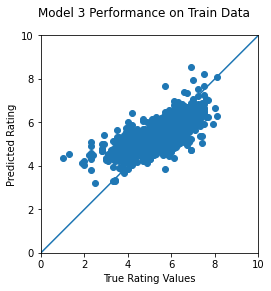

In [38]:
## MODEL 3 PERFORMANCE
#graphing the model predictions vs actuals of training set

train_predictions_3 = model_3.predict(X_train).flatten()

a = plt.axes(aspect='equal')
plt.scatter(Y_train, train_predictions_3)
plt.suptitle('Model 3 Performance on Train Data')
plt.xlabel('True Rating Values')
plt.ylabel('Predicted Rating')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ =plt.plot(lims, lims)

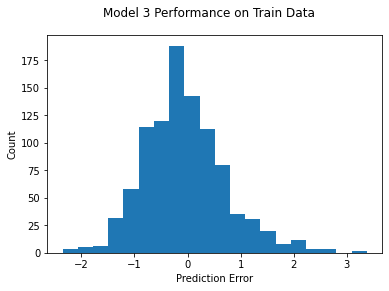

In [39]:
## MODEL 3 PERFORMANCE
#graphing distribution of model error (prediction vs actual) of training set

error_3 = train_predictions_3 - Y_train['vote_average']
plt.hist(error_3, bins=20)
plt.suptitle('Model 3 Performance on Train Data')
plt.xlabel('Prediction Error')
_=plt.ylabel('Count')

### Analysis
As seen above from the results of the training on model 3, it is very accurate in its predictions. There is a clear linear relation between its predictions and the actuals. We can also see in the error distribution that the vast majority of the predictions are within ±1. There is a very high spike at around 0, where the model is making nearly perfect predictions. 
We worry that this is an indication of overfitting, and we will add dropout in model 4 to see how that performs. 

### Model 4
For our fourth model, we used something similar to our third, with 3 hidden layers of 4, 2, 2 nodes as seen above. The important difference with this model is that we also included a dropout layer right after the initial layer. A dropout layer will randomly drop nodes at the specified factor - here we used 0.2 or 20%. Dropout is typically used to help avoid overfitting, as dropping nodes through the training process will stop the algorithm from overlearning certain patterns. Dropout is also usually used on layers with many nodes, hence why we put it after our 8 node layer. 

In [40]:
## KERAS MODEL 4
# Our fourth model will be a neural network similar to model 3, with 3 hidden layers
# however, we will be adding some dropout @ 10% in hopes to avoid overfitting
# we are also running the model for 100 epochs as opposed to 50 from the previous model training

##Defining the model
model_4 = Sequential()
model_4.add(Dense(8, activation='relu', input_shape=(n_features,)))
#hidden layers
model_4.add(keras.layers.Dropout(0.2))
model_4.add(Dense(4, kernel_initializer='he_normal'))
model_4.add(Dense(2, kernel_initializer='he_normal'))
model_4.add(Dense(2, kernel_initializer='he_normal'))
#output node
model_4.add(Dense(1))

# compiling the model
model_4.compile(optimizer='adam', loss='mse')

# fitting the model to the training data
model_4.fit(X_train, Y_train, epochs=100, verbose=1)

Train on 974 samples
Epoch 1/100
974/974 [==============================] - 0s 301us/sample - loss: 30.5720
Epoch 2/100
974/974 [==============================] - 0s 27us/sample - loss: 22.2021
Epoch 3/100
974/974 [==============================] - 0s 26us/sample - loss: 10.9363
Epoch 4/100
974/974 [==============================] - 0s 25us/sample - loss: 3.6528
Epoch 5/100
974/974 [==============================] - 0s 25us/sample - loss: 3.0320
Epoch 6/100
974/974 [==============================] - 0s 24us/sample - loss: 2.9232
Epoch 7/100
974/974 [==============================] - 0s 25us/sample - loss: 2.6053
Epoch 8/100
974/974 [==============================] - 0s 25us/sample - loss: 2.3092
Epoch 9/100
974/974 [==============================] - 0s 25us/sample - loss: 2.0905
Epoch 10/100
974/974 [==============================] - 0s 24us/sample - loss: 2.1752
Epoch 11/100
974/974 [==============================] - 0s 24us/sample - loss: 1.9252
Epoch 12/100
974/974 [================

974/974 [==============================] - 0s 24us/sample - loss: 0.5880
Epoch 97/100
974/974 [==============================] - 0s 25us/sample - loss: 0.5698
Epoch 98/100
974/974 [==============================] - 0s 25us/sample - loss: 0.5823
Epoch 99/100
974/974 [==============================] - 0s 24us/sample - loss: 0.6096
Epoch 100/100
974/974 [==============================] - 0s 25us/sample - loss: 0.6017


### Model 4 Performance

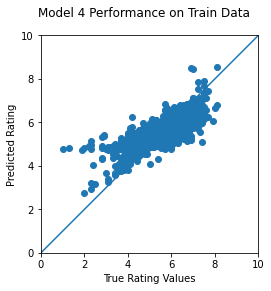

In [53]:
## MODEL 4 PERFORMANCE
#graphing the model predictions vs actuals of training set

train_predictions_4 = model_4.predict(X_train).flatten()

a = plt.axes(aspect='equal')
plt.scatter(Y_train, train_predictions_4)
plt.suptitle('Model 4 Performance on Train Data')
plt.xlabel('True Rating Values')
plt.ylabel('Predicted Rating')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ =plt.plot(lims, lims)

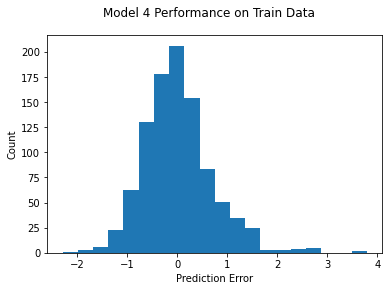

In [54]:
## MODEL 4 PERFORMANCE
#graphing distribution of model error (prediction vs actual) of training set

error_4 = train_predictions_4 - Y_train['vote_average']
plt.hist(error_4, bins=20)
plt.suptitle('Model 4 Performance on Train Data')
plt.xlabel('Prediction Error')
_=plt.ylabel('Count')

### Analysis
The addition of dropout seemed to improve the model. Based on the distribution of prediction error, we can see that there is a tighter distribution of the error, and more predictions with near-0 error (note that the y axis here is up to 250 as opposed to 200 of model 3). We, however, expect this model to perform better than model 3 on unseen data as well because of this dropout feature, and this is why we used model 4 as our final model moving forwards with our testing. 

### Model 4 - Performance on Unseen Data

In [55]:
## MODEL PERFORMANCE ON TEST DATA

## We are now going to move forward with model #
## 

# Evaluating the model on our test set
MSE = model_4.evaluate(X_test, Y_test, verbose=1)
print('MSE: %.5f, RMSE: %.5f' % (MSE, math.sqrt(MSE)))

244/244 [==============================] - 0s 27us/sample - loss: 0.7659
MSE: 0.76586, RMSE: 0.87513


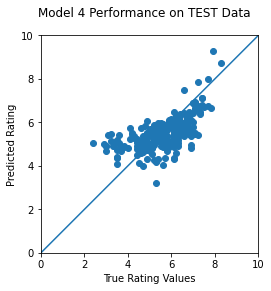

In [56]:
## MODEL 4 PERFORMANCE on TEST
#graphing the model predictions vs actuals of TEST set

test_predictions = model_4.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_predictions)
plt.suptitle('Model 4 Performance on TEST Data')
plt.xlabel('True Rating Values')
plt.ylabel('Predicted Rating')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ =plt.plot(lims, lims)

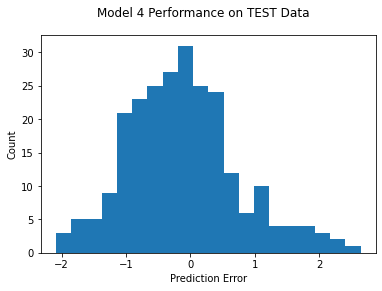

In [58]:
## MODEL 4 PERFORMANCE on TEST
#graphing distribution of model error (prediction vs actual) of TEST set

error = test_predictions - Y_test['vote_average']
plt.hist(error, bins=20)
plt.suptitle('Model 4 Performance on TEST Data')
plt.xlabel('Prediction Error')
_=plt.ylabel('Count')

### Analysis
Above we see the results of the chosen Model 4’s performance on the test set of data. We graphed the predictions vs actuals and displayed a distribution of the prediction error of the model, like we did previously in evaluating the other models. The important thing to note is that this was done by predicting based on unseen test data.

We can conclude that Model 4 seems to be quite accurate on the training set it was fitted on, as well as new data of the test set. Its performance on the test set is what we are most interested in though it is less accurate than the training counterpart, the important part of a model is how it performs on unseen data, and we think this model does a very good job and is not overfitted on the training set based on these results.

#### Additional Information
Below is the output of the weights used by Model 4
There are many layers and nodes thus why it is hard to interpret.

In [46]:
## Weights of the layers of the model
weights = model_4.get_weights()
print(weights)

[array([[-0.22185683, -0.07160753, -0.24896988, ..., -0.14000224,
         0.04736028, -0.3668049 ],
       [-0.2668189 , -0.11706907, -0.09285116, ...,  0.16009726,
         0.2848385 , -0.38661492],
       [-0.21261662, -0.00185937, -0.09071489, ...,  0.19532418,
         0.08091681,  0.03931992],
       ...,
       [ 0.00075515, -0.11847421,  0.02220104, ..., -0.3449855 ,
        -0.09427589, -0.02343266],
       [-0.15412259, -0.01022694, -0.070156  , ..., -0.07439899,
        -0.02723753, -0.10711254],
       [-0.12616484, -0.03210277, -0.11033424, ...,  0.0240974 ,
         0.04036486,  0.1566577 ]], dtype=float32), array([-0.03702541,  0.0572979 , -0.07237768,  0.02180263,  0.02098448,
       -0.04615645,  0.08344428, -0.06804796], dtype=float32), array([[-0.6184493 ,  0.40326926,  1.009877  , -0.5275022 ],
       [ 0.13494702, -0.6943541 , -0.09887252,  0.408125  ],
       [-0.90126634,  0.15032543,  0.88012034, -0.9240401 ],
       [-0.21145573, -0.43170276,  0.09095876,  0.31

## Unsupervised Learning Tasks

### K-Means Clustering

Text(0.5, 1.0, 'K-Means Classification')

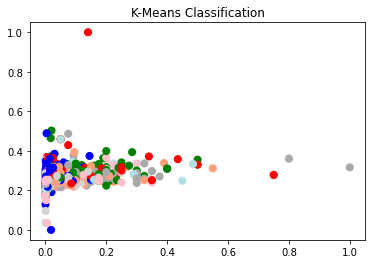

In [47]:
## CLUSTERING
# data we will be using for now is the same data_x as before,
# will take only top movies and do clustering afterwards

clustering = KMeans(n_clusters= 8, random_state=10)
clustering.fit(data_x)

color_theme = np.array(['darkgray','lightsalmon','powderblue', 'green', 'red', 'blue', 'pink', 'lightgray'])
#plt.subplot(1,2,2)
plt.scatter(x=data_x['budget'],y=data_x['runtime'],c=color_theme[clustering.labels_],s=50)
plt.title('K-Means Classification')

In [48]:
# Get Clusters
cluster_map = pd.DataFrame()
cluster_map['data_index'] = data_x.index.values
cluster_map['cluster'] = clustering.labels_

#cluster_map[cluster_map.cluster == 3]
cluster_map.head()

,data_index,cluster
0,1,1
1,2,2
2,3,4
3,4,7
4,9,0


### Analysis
The first thing to note is that the visualization of the clustering is not a good representation of the clusters. We clustered the data based on all the features we used in our final dataset, which include budget, runtime, vote count, revenue, genre, language, year, month, and production country. Of these, only budget, runtime, vote count, and revenue are continuous variables, which we used to display the clustering in a 2D visualization. We used 8 clusters for this algorithm, though they are difficult to see with this way of visualizing. We think that this is because the points are largely clustered based on the other features, of which we cannot properly display here. 

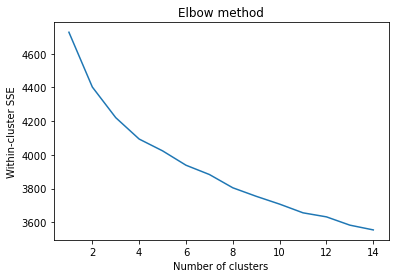

In [49]:
#Elbow method
distortations = {}
for k in range(1,15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data_x)
  distortations[k] = kmeans.inertia_

plt.plot(list(distortations.keys()),list(distortations.values()))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

### Analysis
Using the Elbow Method (learnt from class tutorial) we tried to find the optimal number of clusters. We settled on 8, which we can see from the graph that there is a ‘kink’ in the graph at this location, being the elbow we are looking for. Typically there would be a more distinct elbow, hence the name of the method, where we would determine the optimal number of clusters for the dataset because of the reduction in slope of our within-cluster SSE. Though the slope seems to return after 10, there is a noticeable reduction at 8 which is why we used it. Given the size of the dataset and the large number of features, we don’t think it is a dataset that lends well to clustering. Perhaps a much larger number of clusters is required. Further analysis is required to determine any further conclusions from this exercise.

## Apriori Association Rule Mining

In [50]:
## get data with just categorical attributes
data_cat = data_x.copy()
del data_cat['budget']
del data_cat['revenue']
del data_cat['runtime']
del data_cat['vote_count']
#data_cat.head()


In [51]:
## APRIORI

frequent_sets = apriori(data_cat, min_support=0.1, use_colnames=1)

print(frequent_sets)

     support                                         itemsets
0   0.920361                                             (en)
1   0.105911                                              (1)
2   0.111658                                              (8)
3   0.123153                                             (10)
4   0.133826                                         (Action)
5   0.127258                                         (Comedy)
6   0.169951                                          (Drama)
7   0.154351                                        (Mystery)
8   0.206897                                (Science Fiction)
9   0.492611                                       (Thriller)
10  0.109195                                         (Canada)
11  0.772578                       (United States of America)
12  0.105911                                          (8, en)
13  0.114943                                         (10, en)
14  0.124795                                     (Action, en)
15  0.11

### Analysis
We also used Apriori to try and determine some association rules within the dataset. We used a low support of 0.1 to see more possibilities. We can see from the above that the highest supports were for language being english and for the production company being the United States, as well as the combination (en, United States).  This is important as it is what leads to the association rules seen below being so centered on these two attributes.

In [52]:
rules = association_rules(frequent_sets, metric='confidence', min_threshold=0.8)

print(rules.columns)

print(rules[['antecedents', 'consequents', 'support', 'confidence']])

Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction'],
      dtype='object')
                                    antecedents  \
0                                           (8)   
1                                          (10)   
2                                      (Action)   
3                                      (Comedy)   
4                                       (Drama)   
5                                     (Mystery)   
6                             (Science Fiction)   
7                                    (Thriller)   
8                                      (Canada)   
9                    (United States of America)   
10                                         (en)   
11                                         (10)   
12                                     (Action)   
13                                     (Comedy)   
14                            (Science Fiction)   
15     

### Analysis
The confidence factor we chose was 0.8, though the results would look similar with a higher confidence factor as well. We can see that the overwhelming amount of records for english and United States causes the association consequents to be this for various antecedents. This is something we had not anticipated prior to conducting this exercise and seeing the results of the apriori method. In the future, we think this could be a good method to use to draw some conclusions if the dataset was more evenly distributed between factors. 



## Project Conclusions
We set out on this project to predict the ratings of horror movies. We thought it would be a unique experiment given the intricacies of the horror genre. After collecting and cleansing Our data we ended up with approximately 1200 movies.

We experimented with 4 supervised learning models. The first model had 1 hidden layer and few nodes, the second model and 2 hidden layers and more nodes, the third model had 3 hidden layers  and lastly, the fourth model had 3 hidden layers and a 10% dropout.  The 10% dropout was included in the fourth model to decrease the overfitting that occurs as the number of hidden layers decreases. As the number of layers increased, the accuracy of the predictions also increased especially in the jump from two to three hidden layers. When comparing the training vs testing results of the fourth model, it is still relatively successful but less accurate than any of the models on the training data set of course.

For the K means clustering algorithm, we set the number of clusters to 8 using the elbow method. We were not able to gain many distinct conclusions from the clustering algorithm through visual analysis. Further analysis is required to receive value from it, though they were indeed clustered.

For the association rule mining many of the rules with the highest support and confidence revolved around combinations including the united states and english. Upon reflection many of these rules were trivial for example, movies in the united States being in english. This is likely due to our dataset skewing to american and english movies. 

Unfortunately, we  were not able to draw many non-trivial conclusions from the clustering and association rule mining given our level of support and confidence. Many of the rules found were trivial or non-insightful.

The supervised learning model built proves accurate on new data and we are excited to see where we can take this project to further increase the predicting power of our model and gain more insights on the horror movie space.

### Lessons Learnt
One of the main lessons learned from this project was that it would be useful to conduct analysis on groups of the one-hot explanatory variables. For example, for countries of origin, one of the obvious or trivial insights was that most movies were made in the United States and with the language being english. However, it would have been interesting to examine the other regional patterns, for example, european and asian movies. However, given that the data was in country form it could not be done easily. Grouping Ratings and Revenue into different groups would have also provided valuable analysis. Similarly, it is possible that movies should have had their year of release variable replaced by a decade of release, as it may have been easier to discover trends then.

Another lesson learned is that when analyzing a subset of a dataset, i.e. horror movies in a movie dataset more data is needed. This is because much of the dataset will be removed as it is not part of the subset. For example, we started off with 45,000 movies while after filtering and processing finished with approximately 1200 movies.

Another lesson we learned is to apply testing data to every model and to use K Fold validation vs a train test data split. We only compared the accuracy on training data and not testing data, when in reflecting we should have run every supervised training model through the testing dataset.